[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

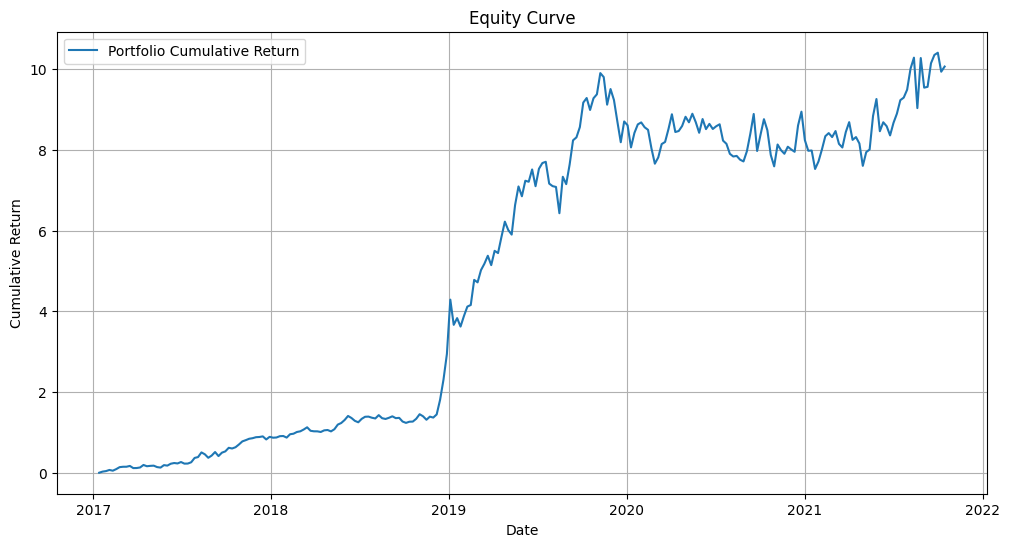

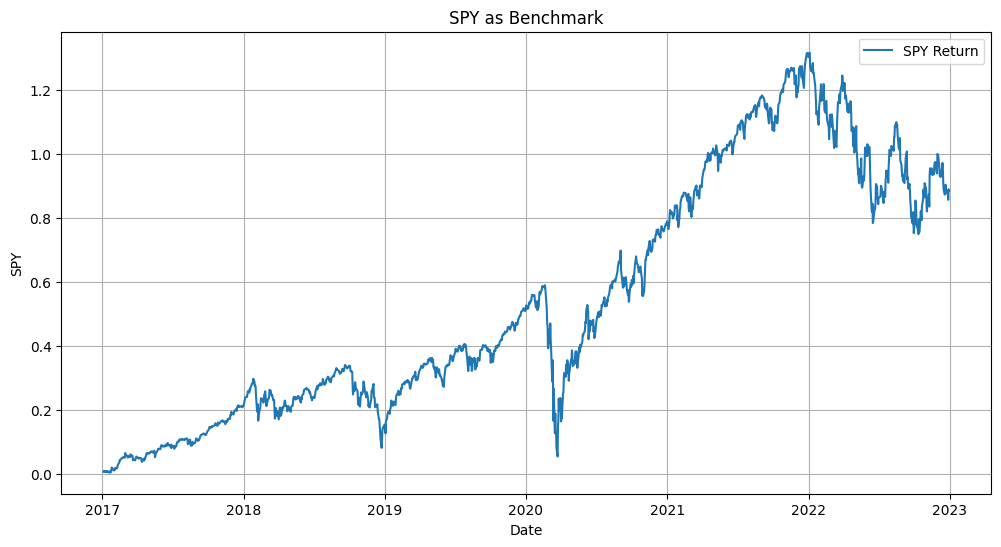

In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


# Read the NFCI data
nfci_data = pd.read_csv('nfci.csv')
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
nfci_data.set_index('date', inplace=True)
nfci_data['nfci_sma_14'] = nfci_data['NFCI'].rolling(window=2).mean()

# Download VIXM data and resample to weekly
vixm_data = yf.download("VIXM", start="2017-01-01", end="2023-01-01")
vixm_data = vixm_data.resample('W-FRI').last()  # Resample to weekly data
vixm_data["VIXM_return"] = vixm_data["Adj Close"].pct_change()



# Function to calculate CAGR
def calculate_cagr(end_value, start_value, periods):
    return (end_value/start_value)**(1/periods) - 1

# Function to calculate Max Drawdown
def calculate_max_drawdown(cumulative_return):
    peak = cumulative_return.expanding(min_periods=1).max()
    drawdown = (cumulative_return - peak) / peak
    return drawdown.min()

# List of ETFs to backtest
etfs = [
    "XES", "XOP", "XHB", "XME", "XSD", "XSW", "XAR", "XTN", "XHS", "XHE",
    "XBI", "KRE", "KBE", "KIE", "KCE", "XWEB", "XPH", "XRT", "XTL", "XLU",
    "XLB", "PBJ"
]

# Initialize an empty DataFrame to store ETF returns
etf_returns = pd.DataFrame()

# Download historical data for each ETF and resample to weekly
for etf in etfs:
    data = yf.download(etf, start="2017-01-01", end="2023-01-01")
    data = data.resample('W-FRI').last()  # Resample to weekly data
    data[f"{etf}_return"] = data["Adj Close"].pct_change()
    etf_returns = pd.concat([etf_returns, data[f"{etf}_return"]], axis=1)

# Drop the first row as it will contain NaN 
etf_returns = etf_returns.dropna()

# Add VIXM data to the etf_returns DataFrame
etf_returns["VIXM_return"] = vixm_data["VIXM_return"]
# Merge NFCI data with ETF data
etf_returns = etf_returns.join(nfci_data, how='inner')

# Create a risk-off signal based on NFCI
etf_returns['signal'] = np.where(etf_returns['NFCI'] > etf_returns['nfci_sma_14'], 0, 1)

# Backtest the momentum strategy with NFCI risk-off signal
def backtest_momentum(df, lookback_period=63, rebalance_period=252):
    portfolio_return = []
    for i in range(0, len(df) - lookback_period, rebalance_period):
        lookback_data = df.iloc[i:i+lookback_period]
        
        # Filter out non-numeric columns for the idxmax operation
        lookback_data_numeric = lookback_data.select_dtypes(include=[np.number]).drop(columns=['signal'])
        
        recent_returns = lookback_data_numeric.sum()
        best_etf = recent_returns.idxmax()
        
        rebalance_data = df.iloc[i+lookback_period:i+lookback_period+rebalance_period]
        
        # Shift the NFCI signal to eliminate look-ahead bias
        nfci_signal = df['signal'].iloc[i+lookback_period:i+lookback_period+rebalance_period].shift(1)
        
        # Apply the strategy only when NFCI signal is 1 (risk-on)
        etf_return = rebalance_data[best_etf] * nfci_signal
        
        # Invest in VIXM when NFCI signal is 0 (risk-off)
        vixm_return = rebalance_data['VIXM_return'] * (1 - nfci_signal)
        
        # Combine the returns
        combined_return = etf_return.fillna(0) + vixm_return.fillna(0)
        
        portfolio_return.extend(combined_return.dropna().tolist())
    
    return pd.Series(portfolio_return, name="Portfolio Return")



# Create a date index from the original etf_returns DataFrame
date_index = etf_returns.index

# Download SPY data for the same time period
spy_data = yf.download("SPY", start="2017-01-01", end="2023-01-01")
spy_data["SPY_return"] = spy_data["Adj Close"].pct_change()
spy_data = spy_data.dropna()

# Calculate the cumulative return for SPY
spy_cumulative_return = (1 + spy_data["SPY_return"]).cumprod() - 1

# Initialize variables to store the best parameters and highest CAGR/Max Drawdown ratio
best_params = None
highest_ratio = -float('inf')

# Run the backtest with the best parameters
portfolio_return = backtest_momentum(etf_returns)
cumulative_return = (1 + portfolio_return).cumprod() - 1

# Set the date index for the cumulative_return series
cumulative_return.index = date_index[:len(cumulative_return)]

# Calculate performance metrics for the strategy and SPY
strategy_cagr = calculate_cagr(cumulative_return.iloc[-1] + 1, 1, len(cumulative_return) / 252)
strategy_max_drawdown = calculate_max_drawdown(cumulative_return)

spy_cagr = calculate_cagr(spy_cumulative_return.iloc[-1] + 1, 1, len(spy_cumulative_return) / 252)
spy_max_drawdown = calculate_max_drawdown(spy_cumulative_return)

# Print performance metrics
print(f"Strategy CAGR: {strategy_cagr:.4f}")
print(f"Strategy Max Drawdown: {strategy_max_drawdown:.4f}")
print(f"SPY CAGR: {spy_cagr:.4f}")
print(f"SPY Max Drawdown: {spy_max_drawdown:.4f}")

# Plot the equity curve along with SPY as a benchmark
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return.index, cumulative_return, label='Portfolio Cumulative Return')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot the equity curve for SPY as a benchmark
plt.figure(figsize=(12, 6))
plt.plot(spy_cumulative_return.index, spy_cumulative_return, label='SPY Return')
plt.title('SPY as Benchmark')
plt.xlabel('Date')
plt.ylabel('SPY')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  2 of 2 completed
Weekly CAGR: 55.92%


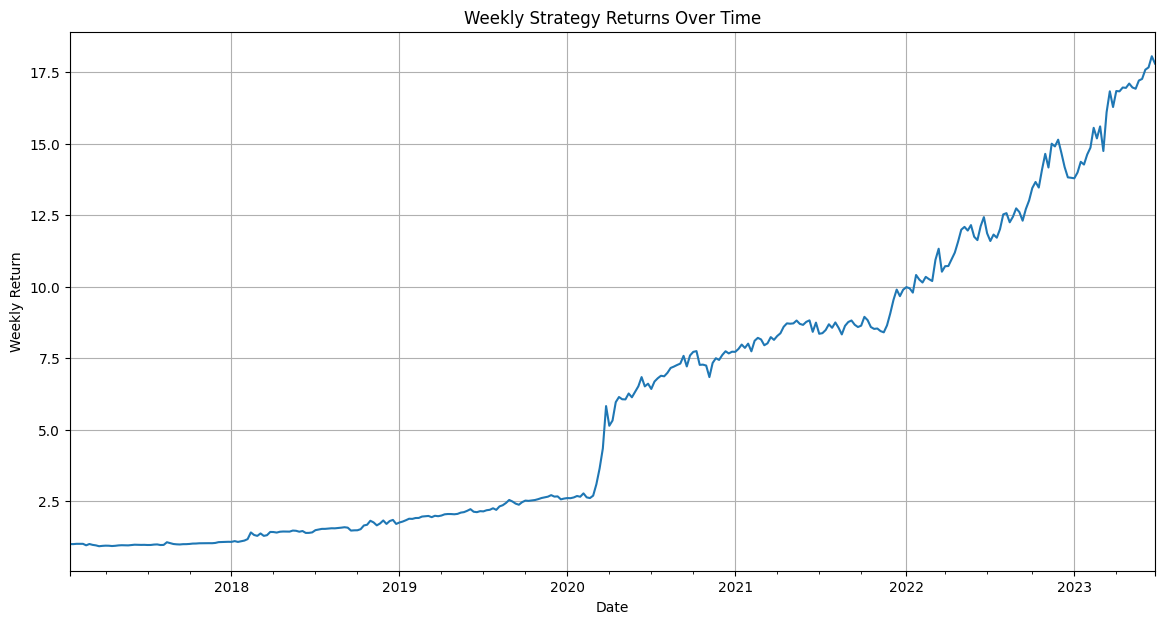

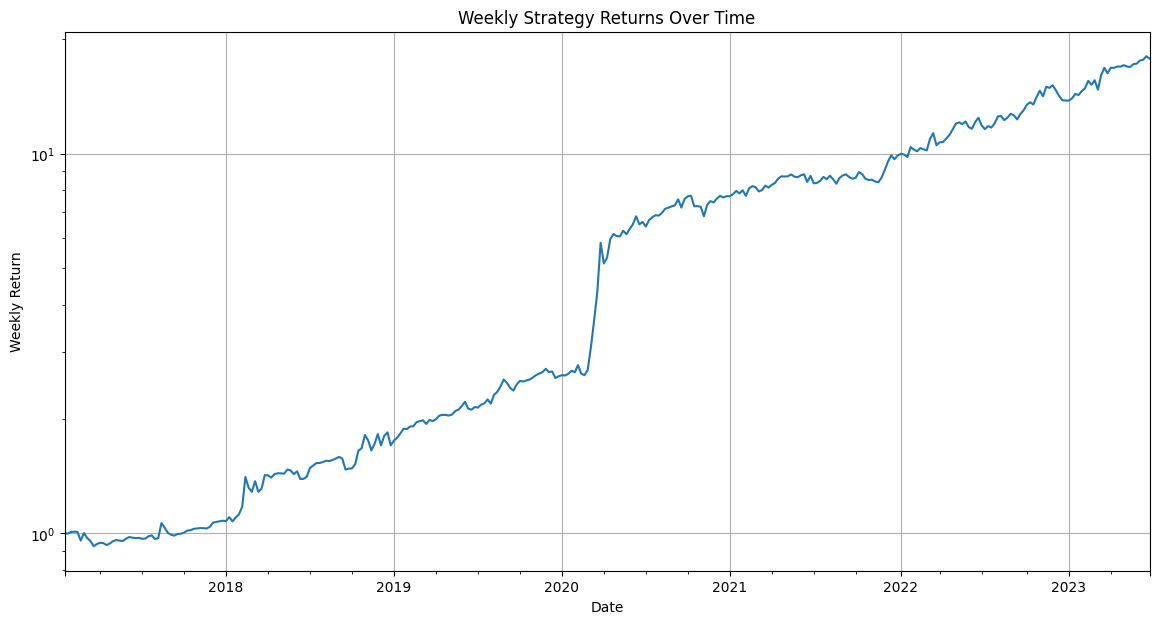

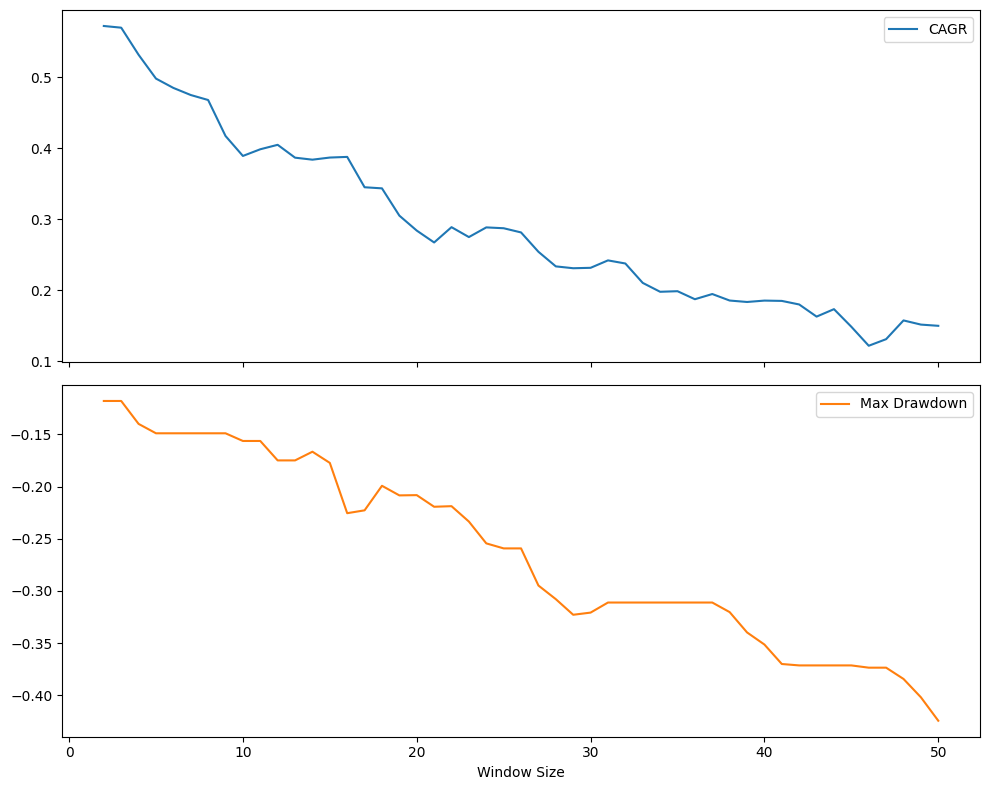

Strategy on Test Data: CAGR: 51.30%


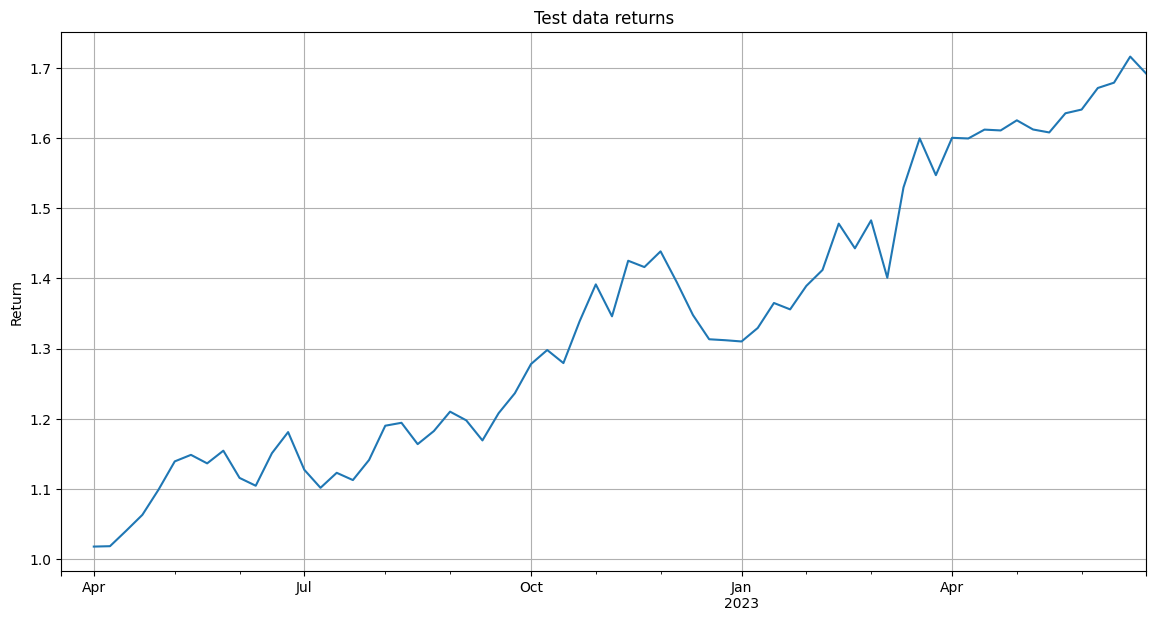

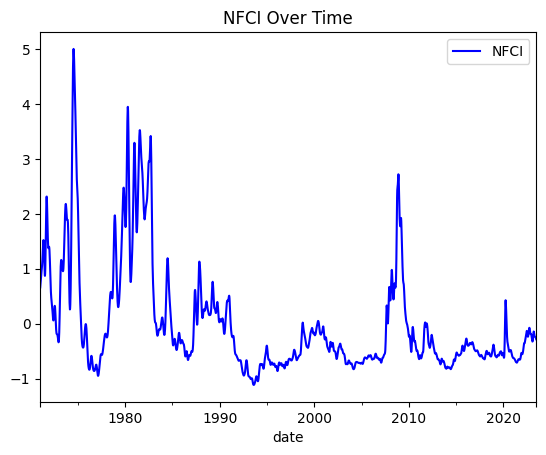

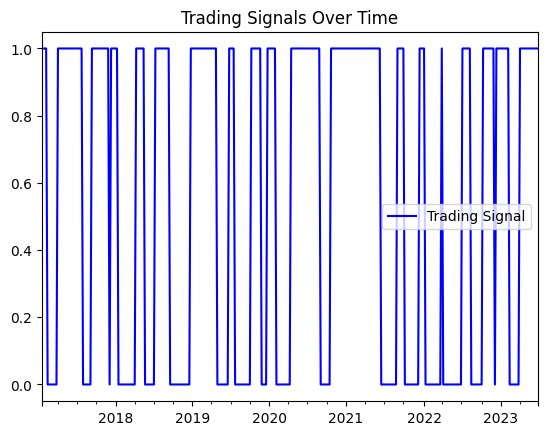

Latest Date: 2023-06-30 00:00:00, Latest Signal Value: 1
Correlation between SPY and VIXM: -0.7566
Annual Returns:
2017    0.084198
2018    0.587204
2019    0.528572
2020    1.997429
2021    0.287325
2022    0.403010
2023    0.292389
Name: strategy_returns, dtype: float64


In [49]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Read the data
nfci_data = pd.read_csv('nfci.csv')
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
nfci_data.set_index('date', inplace=True)

# Calculate the 14-day moving average
nfci_data['nfci_sma_14'] = nfci_data['NFCI'].rolling(window=2).mean()
# Shift the 14-day moving average by one day
nfci_data['nfci_sma_14_shifted'] = nfci_data['nfci_sma_14'].shift(1)

# Download IJJ and VIXM data
symbols = ['SPY','VIXM']
prices_data = yf.download(symbols, start='2017-01-03', end=nfci_data.index.max())['Close']
prices_data = prices_data.resample("W-FRI").last()

# Saving trade log
prices_data.to_csv('prices_data.csv')

# Merge the dataframes
data = prices_data.join(nfci_data, how='inner')

# Create a signal
data['signal'] = np.where(data['NFCI'] < data['nfci_sma_14_shifted'], 1, 0)

# Calculate strategy returns
data['strategy_returns'] = np.where(data['signal'] == 1, data['SPY'].shift(1).pct_change(), data['VIXM'].shift(1).pct_change())
data['SPY_returns'] = data['SPY'].pct_change()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']-0.0001).cumprod()
# Calculate the total period in years
total_years = (data.index[-1] - data.index[0]).days / 365.0
# Calculate CAGR using the final cumulative return value
end_value = data['cumulative_strategy_returns'].iloc[-1]
cagr_weekly = (end_value) ** (1 / total_years) - 1

print(f"Weekly CAGR: {cagr_weekly*100:.2f}%")

# Drop missing values
data.dropna(inplace=True)
# Plotting weekly strategy returns

plt.figure(figsize=(14, 7))
data['cumulative_strategy_returns'].plot()
plt.title('Weekly Strategy Returns Over Time')
plt.ylabel('Weekly Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Plotting weekly strategy returns
plt.figure(figsize=(14, 7))
data['cumulative_strategy_returns'].plot()
plt.title('Weekly Strategy Returns Over Time')
plt.ylabel('Weekly Return')
plt.yscale("log")
plt.xlabel('Date')
plt.grid(True)
plt.show()

def evaluate_strategy(window_size, data):
    data['nfci_sma'] = data['NFCI'].rolling(window=window_size).mean()
    data['nfci_sma_shifted'] = data['nfci_sma'].shift(1)
    data['signal'] = np.where(data['NFCI'] < data['nfci_sma_shifted'], 1, 0)
    data['strategy_returns'] = np.where(data['signal'] == 1, data['SPY'].shift(1).pct_change(), data['VIXM'].shift(1).pct_change())
    
    years = (data.index[-1] - data.index[0]).days / 365.0
    cagr_strategy = (1 + data['strategy_returns']).cumprod().iloc[-1] ** (1 / years) - 1
    cumulative_returns_strategy = (1 + data['strategy_returns']).cumprod()
    rolling_max_strategy = cumulative_returns_strategy.expanding().max()
    daily_drawdown_strategy = cumulative_returns_strategy / rolling_max_strategy - 1
    max_drawdown_strategy = daily_drawdown_strategy.min()
    
    return {
        'Window Size': window_size,
        'CAGR': cagr_strategy,
        'Max Drawdown': max_drawdown_strategy
    }

# Loop over different window sizes (from 2 to 50, for instance)
results = []
for window in range(2, 51):
    result = evaluate_strategy(window, data.copy())
    results.append(result)
results_df = pd.DataFrame(results)

# Optional: plot the results to visualize them
results_df.set_index('Window Size').plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Splitting data into training (80%) and test (20%)
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size].copy()  # use .copy() to create a copy
test_data = data.iloc[train_size:].copy()   # use .copy() to create a copy


# Strategy design on training data
# For simplicity, let's stick with your 2-day moving average. However, you'd ideally want to test multiple periods here.
train_data['nfci_sma_14'] = train_data['NFCI'].rolling(window=2).mean()
train_data['nfci_sma_14_shifted'] = train_data['nfci_sma_14'].shift(1)
train_data['signal'] = np.where(train_data['NFCI'] < train_data['nfci_sma_14_shifted'], 1, 0)
train_data['strategy_returns'] = np.where(train_data['signal'] == 1, train_data['SPY'].shift(1).pct_change(), train_data['VIXM'].shift(1).pct_change())

# Applying strategy to test data
test_data['nfci_sma_14'] = test_data['NFCI'].rolling(window=2).mean()
test_data['nfci_sma_14_shifted'] = test_data['nfci_sma_14'].shift(1)
test_data['signal'] = np.where(test_data['NFCI'] < test_data['nfci_sma_14_shifted'], 1, 0)
test_data['strategy_returns'] = np.where(test_data['signal'] == 1, test_data['SPY'].shift(1).pct_change(), test_data['VIXM'].shift(1).pct_change())


years = (test_data.index[-1] - test_data.index[0]).days / 365.0
cagr_strategy = (1 + test_data['strategy_returns']).cumprod().iloc[-1] ** (1 / years) - 1

print(f"Strategy on Test Data: CAGR: {cagr_strategy:.2%}")
test_data['cumulative_strategy_returns'] = (1 + test_data['strategy_returns']-0.0001).cumprod()
# Plotting weekly strategy returns
plt.figure(figsize=(14, 7))
test_data['cumulative_strategy_returns'].plot()
plt.title('Test data returns')
plt.ylabel('Return')
plt.grid(True)
plt.show()

# Determine where trades take place (i.e., where the signal changes)
data['trade_executed'] = data['signal'].diff().abs()
# Apply transaction costs on the days trades are executed

# Display the list of all trades with their date
trade_dates = data[data['trade_executed'] == 1].index

# Create a dataframe for the trade log
trade_log = pd.DataFrame(columns=['Start Date', 'End Date', 'Asset', 'Entry Price', 'Exit Price'])

# Iterate over the data to identify trades and record them in the trade log
current_position = None
entry_price = None
for i, row in data.iterrows():
    if row['trade_executed'] == 1:
        if current_position:  # If there's a current position, record the exit trade
            trade_data = pd.DataFrame({
                'Start Date': [trade_start],
                'End Date': [i],
                'Asset': [current_position],
                'Entry Price': [entry_price],
                'Exit Price': [row[current_position]]
            })
            trade_log = pd.concat([trade_log, trade_data], ignore_index=True)
        
        # Update current position and trade start
        current_position = 'SPY' if row['signal'] == 1 else 'VIXM'
        trade_start = i
        entry_price = row[current_position]
        
# Plot the NFCI value over time
nfci_data['NFCI'].plot(label='NFCI', color='b')
plt.title('NFCI Over Time')
plt.legend()
plt.show()

# Plot the trading signals over time
data['signal'].plot(label='Trading Signal', color='b')
plt.title('Trading Signals Over Time')
plt.legend()
plt.show()

# Get the latest date and value
latest_date = data.index[-1]
latest_value = data['signal'].iloc[-1]

# Print the latest date and value
print(f"Latest Date: {latest_date}, Latest Signal Value: {latest_value}")

correlation = data['SPY'].pct_change().corr(data['VIXM'].pct_change())
print(f"Correlation between SPY and VIXM: {correlation:.4f}")


# Determine where trades take place (i.e., where the signal changes)
data['trade_executed'] = data['signal'].diff().abs()

# Create a dataframe for the trade log
trade_log = pd.DataFrame(columns=['Start Date', 'End Date', 'Asset', 'Entry Price', 'Exit Price'])

# Iterate over the data to identify trades and record them in the trade log
current_position = None
entry_price = None
trade_start = None
for i, row in data.iterrows():
    if row['trade_executed'] == 1:
        if current_position:  # If there's a current position, record the exit trade
            trade_data = pd.DataFrame({
                'Start Date': [trade_start],
                'End Date': [i],
                'Asset': [current_position],
                'Entry Price': [entry_price],
                'Exit Price': [row[current_position]]
            })
            trade_log = pd.concat([trade_log, trade_data], ignore_index=True)
        
        # Update current position and trade start
        current_position = 'SPY' if row['signal'] == 1 else 'VIXM'
        trade_start = i
        entry_price = row[current_position]

# Output the trade log to a text file
trade_log.to_csv('trade_log.txt', sep='\t', index=False)

# Calculate annual returns
annual_returns = (data['strategy_returns'] + 1).groupby(data.index.year).prod() - 1

# Display annual returns
print("Annual Returns:")
print(annual_returns)